In [18]:
import yahoo_fin.stock_info as yf
import pandas as pd
import warnings
from datetime import date
import que
import panel as pn
from dateutil.relativedelta import relativedelta
warnings.filterwarnings('ignore')
pn.extension(comms='vscode')


In [19]:
from finquant.moving_average import sma
from finquant.moving_average import compute_ma
import pathlib
import matplotlib.pyplot as plt
import datetime
from finquant.portfolio import build_portfolio

In [20]:
nasdaq_ticker = pd.read_csv('./data/nasdaq_screener.csv')
nasdaq_ticker.sort_values(['Market Cap'],ascending=False)
fifty_largest= nasdaq_ticker.nlargest(50,'Market Cap')
twenty_largest= nasdaq_ticker.nlargest(20,'Market Cap')
ticker_list_twenty = twenty_largest['Symbol'].to_list()
ticker_list = tuple(ticker_list_twenty)

In [56]:
def get_company_financials(ticker_list):
    all_financials = {}
    if not ticker_list:
         return "Please provide atleast one ticker"
    else: 
        # avoid looping through dataframes due to loc index issues
        ticker_list = list(ticker_list)
        for tick in ticker_list:
            ticker_report ={}
            dict_financials  = yf.get_financials(tick,yearly =True, quarterly = False)
            ticker_report["income_statement"]= dict_financials['yearly_income_statement'].fillna(0)
            ticker_report["balance_sheet"] = dict_financials['yearly_balance_sheet'].fillna(0)
            ticker_report["yearly_cash_flow"] = dict_financials['yearly_cash_flow'].fillna(0)
            all_financials[tick] = ticker_report
    return all_financials

In [58]:
def get_company_performance(ticker_list):

    all_performance = {}
    if not ticker_list:
         return "Please provide atleast one ticker"
    else: 
        ticker_list = list(ticker_list)
        for tick in ticker_list:
            performance = {}

            try:
                dividend = yf.get_dividends(tick)
                performance["dividend"] = dividend
                earnings = yf.get_earnings_history(tick)
                performance["earnings"] = pd.DataFrame(earnings)
                all_performance[tick] = performance
                # catch exceptions raised on no data available
            except Exception as e : 
                ticker_list.remove(tick)
                #print(f"No dividend for {tick}") 
                
    return all_performance  



In [60]:
def get_financial_stats(ticker_list):
    all_fin_stats = {}
    if not ticker_list:
         return "Please provide atleast one ticker"
    else:
        ticker_list = list(ticker_list) 
        for tick in ticker_list:
            try:
                fin_stats = yf.get_stats(tick)
                all_fin_stats[tick] = fin_stats
            except Exception as e:
                print(e)
                #ticker_list.remove(tick)
    return all_fin_stats

In [62]:
def persona_return_risk_portfolio(persona_number,score_sort,df_div_payout_ordered,df_Beta):
    # 10 year US give bond = ^TNX
    ten_year_bond_symbol = "^TNX"
    # top 2 crypto 
    bitcoin = "BTC-USD"
    etherum = "ETH-USD"
    p_instruments =[]
    weight_instruments ={}
    five_stocks =score_sort[0:5] 
    if persona_number == 1:
        
        
        weight_instruments[ten_year_bond_symbol] = 0.8
        for st in five_stocks:
            weight= (0.2 /5)
            weight_instruments[st[0]] = weight
        p_instruments.append(weight_instruments)
        return p_instruments
    elif persona_number == 2:
        
        
        five_stocks =score_sort[0:5] 
        weight_instruments[ten_year_bond_symbol] = 0.65
        for st in five_stocks:
            weight= (0.35 /5)
            weight_instruments[st[0]] = weight

        p_instruments.append(weight_instruments)
        return p_instruments
    elif persona_number == 3:
        
        four_stocks =score_sort[0:4] 
        weight_instruments[ten_year_bond_symbol] = 0.4
        # 1 share at 20% 
        best_div_payout = df_div_payout_ordered.head(1).loc[0:1,"Ticker"].values[0]
        weight_instruments[best_div_payout] = 0.2

        for st in four_stocks:
            weight= (0.4 /5)
            weight_instruments[st[0]] = weight

        p_instruments.append(weight_instruments)
        return p_instruments
    elif persona_number == 4:
        
        one = score_sort[0:1][0][0] 
        weight_instruments[one] = 0.1 
        weight_instruments[ten_year_bond_symbol] = 0.05
        # 1 share at 20% 
        best_div_payout = df_div_payout_ordered.head(1).loc[0:1,"Ticker"].values[0]
        weight_instruments[best_div_payout] = 0.2
        weight_instruments[bitcoin] = 0.2
        for st in (df_Beta.sort_values(by="BETA", ascending=False).head(3).index):
            weight= (0.65 / 3)
            weight_instruments[st] = weight

        p_instruments.append(weight_instruments) 
        return p_instruments
    elif persona_number ==5:
        
        weight_instruments[ten_year_bond_symbol] = 0.05
        weight_instruments[bitcoin] = (0.45/2)
        weight_instruments[etherum] = (0.45/2)
        for st in (df_Beta.sort_values(by="BETA", ascending=False).head(3).index):
            weight= (0.5 / 3)
            weight_instruments[st] = weight

        p_instruments.append(weight_instruments)
        return p_instruments
    else: 
        return "Persona identifier should be between one and five"

In [64]:
hypothetical = pd.read_csv("./data/hypo_performance.csv",index_col="Plan")
parameters=['bold_rows', 'index', 'header']
df_pane = pn.widgets.DataFrame(hypothetical,name="hypot")


In [66]:
column = pn.Column('# Risk Tolerance Questions ',sizing_mode="stretch_width",)
i=1
dict_answer = {}
ques_rad =[]
for q in que.questions:
    #print (q['choices'])
    qid = "q" + str(i)
    header = pn.pane.Alert(f"###{q['question']}")
    column.append(header)
    if q == que.q10:
        column.append(df_pane)
    q_options = []
    choices=[]
    for opt in q['choices']:
        q_options.append(opt[1])
        choices.append(opt)         
   
    radio_group = pn.widgets.RadioButtonGroup( name= qid,
        options= q_options,
        button_type='default',)
    ques_rad.append(radio_group)
    column.append(radio_group)
    dict_answer[qid] = choices
    i+=1
    column.append( pn.layout.Divider())   

In [68]:
column

BokehModel(combine_events=True, render_bundle={'docs_json': {'0c31c55b-48b5-484c-af4e-9cb74dc22344': {'defs': …

Column(sizing_mode='stretch_width')
    [0] Markdown(str)
    [1] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [2] RadioButtonGroup(name='q1', options=['More than 60', ...], value='More than 60')
    [3] Divider()
    [4] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [5] RadioButtonGroup(name='q2', options=['Within the next year', ...], value='Within the next year')
    [6] Divider()
    [7] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [8] RadioButtonGroup(name='q3', options=['1 week', '1 month', ...], value='1 week')
    [9] Divider()
    [10] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [11] RadioButtonGroup(name='q4', options=['Less than $50,0...], value='Less than $50,000')
    [12] Divider()
    [13] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [14] RadioButtonGroup(name='q5', options=['Very low', 'Below averag...], value='Very low')
    [15] Divider()
    [16] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [17] RadioButtonGroup(name='q6', options=['Deposit it in bank accou...], value='Deposit it in bank accoun...)
    [18] Divider()
    [19] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [20] RadioButtonGroup(name='q7', options=['Absolute loss', ...], value='Absolute loss')
    [21] Divider()
    [22] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [23] RadioButtonGroup(name='q8', options=['I need to see at least a...], value='I need to see a...)
    [24] Divider()
    [25] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [26] RadioButtonGroup(name='q9', options=['Sell all of your remaini...], value='Sell all of y...)
    [27] Divider()
    [28] Alert(str, css_classes=['alert', 'alert-primary']...], margin=(0, 0, 25, 0), sizing_mode='stretch_width')
    [29] DataFrame(name='hypot', value=     Best Case W...)
    [30] RadioButtonGroup(name='q10', options=['Plan A', 'Plan B', ...], value='Plan A')
    [31] Divider()

In [70]:
q_score =[]
for ans in ques_rad:   
    for opt in dict_answer[ans.name] :
        #print(opt) 
        if ans.value in opt:
            q_score.append(int(opt[0]))   
    
print (q_score)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [72]:
total_score = sum(q_score)
risk_profile ="Unknown"
risk_persona= 0
if total_score < 20:
       risk_profile = "Preservation"
       risk_persona= 1
elif total_score >= 20 and total_score < 40:
    risk_profile = "Conservative"
    risk_persona= 2
elif total_score >= 40 and total_score < 60:
    risk_profile = "Balanced"
    risk_persona= 3
elif total_score >= 60 and total_score <= 80:
    risk_profile = "Aggressive"
    risk_persona= 4
else:
    risk_profile = "All Equity"
    risk_persona= 5

In [74]:
risk_profile

'Preservation'

In [76]:
persona_number= risk_persona

In [78]:
all_financials={}
all_performance={}
while  not (bool(all_financials)):
    all_financials = get_company_financials(ticker_list)



In [82]:
while not (bool(all_performance)):
    all_performance = get_company_performance(ticker_list)

In [17]:
all_financial_stats={}
while not (bool(all_financial_stats)):
    all_financial_stats = get_financial_stats(ticker_list)

In [21]:
#all_performance

In [23]:
beta_stats = {}
df_Beta= pd.DataFrame(columns=["Ticker","BETA"],dtype=object)
df_Beta.set_index("Ticker",inplace=True)
for tick in all_financial_stats.keys():
    fin_df = all_financial_stats[tick]
    if ("Attribute" in fin_df.columns):
        fin_attr = fin_df.set_index("Attribute")
        beta = fin_attr.loc["Beta (5Y Monthly)"].values[0]
       
        df_Beta.loc[tick]=beta
       
    else:
        print (f"Skipped {tick}") 
        # 
df_Beta.dropna(inplace=True)


In [24]:
list_dfs_FCFE  = []
list_dfs_ND2EB = []
cf_labels = ['netBorrowings','capitalExpenditures','depreciation']
is_labels = ["netIncome",'ebit']

df_ratios = pd.DataFrame()
for tick in all_financials.keys():
    stock_ratios ={}
    yearly_cash_flow = all_financials[tick]["yearly_cash_flow"]
    income_stmnt = all_financials[tick]["income_statement"]
    if (cf_labels[0] in yearly_cash_flow.index) and (cf_labels[1] in yearly_cash_flow.index):
         capex = yearly_cash_flow.loc[cf_labels[1]]
         net_borrow = yearly_cash_flow.loc[cf_labels[0]]
         depreciation = yearly_cash_flow.loc[cf_labels[2]]
    else: 
        #print(tick)
        del all_financials[tick]    
    if is_labels[0] in income_stmnt.index:
        net_income = income_stmnt.loc["netIncome"]
        ebit = income_stmnt.loc["ebit"]
    else: 
        #print(tick)
        del all_financials[tick]
    FCFE = net_income - capex + net_borrow
    ND_to_EB = net_borrow / (ebit + depreciation)
    #print(f"Ticker {tick} has FCFE of {FCFE}")
    df_FCFE = pd.DataFrame(FCFE).transpose()
    df_ND2EB = pd.DataFrame(ND_to_EB).transpose()
    
    df_ND2EB.columns = df_ND2EB.columns.year
    df_ND2EB['Ticker'] = pd.Series(tick, index=df_ND2EB.index)
    list_dfs_ND2EB.append(df_ND2EB)
    
    df_FCFE.columns = df_FCFE.columns.year
    df_FCFE['Ticker'] = pd.Series(tick, index=df_FCFE.index)
    list_dfs_FCFE.append(df_FCFE)
   

In [26]:
#concat and clean
df_all_ND2EB = pd.concat(list_dfs_ND2EB).set_index("Ticker")
df_all_ND2EB = df_all_ND2EB.drop(columns=(min(df_all_ND2EB.columns) + 4),axis=1,errors='ignore')
df_all_FCFE = pd.concat(list_dfs_FCFE).set_index("Ticker")
df_all_FCFE= df_all_FCFE.drop(columns=(min(df_all_FCFE.columns) + 4),axis=1,errors='ignore')
df_all_ND2EB.columns.name= "year"
df_all_FCFE.columns.name= "year"

In [27]:
all_div_payout= []
all_div_coverage=[]

for tick in all_performance.keys():
    
    divi = all_performance[tick]['dividend']
    ann_total_divi = divi.groupby(divi.index.year).sum()
    ann_total_divi = ann_total_divi.T
    ann_total_divi = ann_total_divi[ann_total_divi.columns.intersection(df_all_FCFE.columns)]
   
    earnings = all_performance[tick]['earnings']
    eps = earnings[["startdatetime","epsactual"]]
    eps.loc[:, ("startdatetime")] = pd.to_datetime(eps.loc[:, ("startdatetime")], errors="coerce",format="%Y-%m-%d")
    eps_annual = eps.groupby(eps.loc[:, ("startdatetime")].dt.year).sum()
    eps_annual = eps_annual.T
    eps_annual = eps_annual[eps_annual.columns.intersection(df_all_FCFE.columns)]
    div_coverage = pd.DataFrame(eps_annual.loc['epsactual'] / ann_total_divi.loc["dividend"]).T
    div_coverage["Ticker"] = tick
    div_coverage =div_coverage.set_index("Ticker")
    all_div_coverage.append(div_coverage.dropna())
   
    div_payout =  pd.DataFrame(ann_total_divi.loc["dividend"] / eps_annual.loc['epsactual']).T
    div_payout["Ticker"] = tick
    div_payout =div_payout.set_index("Ticker")
    all_div_payout.append(div_payout.dropna())
   

In [28]:
#concat and clean
df_div_payout = pd.concat(all_div_payout)
df_div_payout.columns.name= "year"
df_div_coverage= pd.concat(all_div_coverage)
df_div_coverage.columns.name= "year"

In [29]:
df_div_payout['mean'] = df_div_payout.mean(axis=1)

In [30]:
df_div_payout_ordered = df_div_payout.sort_values(by=['mean'], ascending= False)
df_div_payout_ordered = df_div_payout_ordered.reset_index()

In [31]:
df_div_coverage['mean'] = df_div_coverage.mean(axis=1)

In [32]:
df_div_coverage_ordered = df_div_coverage.sort_values(by=['mean'], ascending= False)
df_div_coverage_ordered = df_div_coverage_ordered.reset_index()
#df_div_coverage_ordered

In [33]:
df_all_FCFE['mean'] = df_all_FCFE.mean(axis=1)

In [34]:
df_all_FCFE

year            2020          2019          2018          2017          mean
Ticker                                                                      
AAPL    6.721900e+10  5.793200e+10  7.327600e+10  8.981600e+10  7.206075e+10
MSFT    5.420400e+10  4.916500e+10  1.800200e+10  6.507700e+10  4.661200e+10
AMZN    6.036700e+10  1.838300e+10  1.581400e+10  2.491600e+10  2.987000e+10
GOOG    7.221100e+10  5.762300e+10  5.581400e+10  2.576000e+10  5.285200e+10
GOOGL   7.221100e+10  5.762300e+10  5.581400e+10  2.576000e+10  5.285200e+10
FB      4.368100e+10  3.281200e+10  3.652700e+10  2.316700e+10  3.404675e+10
TSLA    1.465000e+09  1.368000e+09  1.432000e+09  5.504000e+09  2.442250e+09
NVDA    8.253000e+09  4.725000e+09  2.828000e+09           NaN  5.268667e+09
PYPL    9.034000e+09  6.118000e+09  3.840000e+09  3.282000e+09  5.568500e+09
INTC    4.107400e+10  3.802600e+10  3.363100e+10  2.101500e+10  3.343650e+10
ASML    5.998700e+09  3.355100e+09  3.162800e+09  2.162600e+09  3.669800e+09
CMCSA   2.107800e+10  1.913800e+10  5.832700e+10  3.555300e+10  3.352400e+10
NFLX    4.268782e+09  6.589257e+09  5.347040e+09  3.752741e+09  4.989455e+09
ADBE    5.673000e+09  3.340000e+09  5.106000e+09  1.870116e+09  3.997279e+09
CSCO    1.794000e+09  1.144600e+10 -7.056000e+09  1.589900e+10  5.520750e+09
AVGO    1.112600e+10  1.639000e+10  1.192100e+10  6.519000e+09  1.148900e+10
PEP     2.265300e+10  1.119100e+10  8.835000e+09  9.876000e+09  1.313875e+10
TXN     7.242000e+09  6.605000e+09  7.711000e+09  4.851000e+09  6.602250e+09
PDD     6.793529e+09  9.207360e+08 -2.328891e+09  7.344709e+09  3.182521e+09
TMUS    2.733100e+10  7.686000e+09  6.574000e+09  9.237000e+09  1.270700e+10

In [35]:
df_all_ND2EB['mean'] = df_all_ND2EB.mean(axis=1)
df_all_ND2EB


year        2020      2019      2018        2017        mean
Ticker                                                      
AAPL    0.032310 -0.102240  0.005281    0.405785    0.085284
MSFT   -0.084555 -0.073315 -0.226901    0.847244    0.115618
AMZN   -0.022928 -0.278120 -0.276853    0.637064    0.014790
GOOG    0.175965 -0.005568 -0.001466   -0.002401    0.041633
GOOGL   0.175965 -0.005568 -0.001466   -0.002401    0.041633
FB     -0.014671 -0.022317  0.017107    0.021526    0.000411
TSLA   -0.582261  0.367403  0.054434  846.250000  211.522394
NVDA    1.539510 -0.003935 -0.238193         NaN    0.432461
PYPL    0.923399  0.866315  0.351262    0.302583    0.610890
INTC    0.158438  0.023005 -0.080516   -0.013703    0.021806
ASML    0.333258 -0.001204 -0.000827   -0.085162    0.061516
CMCSA  -0.004347 -0.146370  1.205437    0.115390    0.292527
NFLX    0.214734  1.650510  2.346536    3.317091    1.882218
ADBE   -0.001248 -0.001557  0.705587   -0.000786    0.175499
CSCO   -0.644040 -0.068022 -0.540687    0.363450   -0.222325
AVGO    0.690542  1.305257 -0.101693    0.506060    0.600041
PEP     0.855336 -0.027441 -0.553814    0.160507    0.108647
TXN     0.149895  0.110961  0.131718    0.068795    0.115342
PDD    -1.623596 -1.004309 -1.807511  -13.472931   -4.477087
TMUS    0.561410 -0.167696 -0.154699   -0.050390    0.047156

In [36]:
df_with_divi_FCFE = df_all_FCFE[df_all_FCFE.index.isin(df_div_payout.index)].sort_values(by=['mean'], ascending= False)

df_with_divi_FCFE = df_with_divi_FCFE.reset_index()
df_with_divi_FCFE

year Ticker          2020          2019          2018          2017  \
0      AAPL  6.721900e+10  5.793200e+10  7.327600e+10  8.981600e+10   
1      MSFT  5.420400e+10  4.916500e+10  1.800200e+10  6.507700e+10   
2     CMCSA  2.107800e+10  1.913800e+10  5.832700e+10  3.555300e+10   
3       PEP  2.265300e+10  1.119100e+10  8.835000e+09  9.876000e+09   
4      AVGO  1.112600e+10  1.639000e+10  1.192100e+10  6.519000e+09   
5       TXN  7.242000e+09  6.605000e+09  7.711000e+09  4.851000e+09   
6      CSCO  1.794000e+09  1.144600e+10 -7.056000e+09  1.589900e+10   
7      ASML  5.998700e+09  3.355100e+09  3.162800e+09  2.162600e+09   

year          mean  
0     7.206075e+10  
1     4.661200e+10  
2     3.352400e+10  
3     1.313875e+10  
4     1.148900e+10  
5     6.602250e+09  
6     5.520750e+09  
7     3.669800e+09

In [37]:
df_with_divi_ND2EB = df_all_ND2EB[df_all_ND2EB.index.isin(df_div_payout.index)].sort_values(by=['mean'], ascending= False)
df_with_divi_ND2EB = df_with_divi_ND2EB.reset_index()
df_with_divi_ND2EB

year Ticker      2020      2019      2018      2017      mean
0      AVGO  0.690542  1.305257 -0.101693  0.506060  0.600041
1     CMCSA -0.004347 -0.146370  1.205437  0.115390  0.292527
2      MSFT -0.084555 -0.073315 -0.226901  0.847244  0.115618
3       TXN  0.149895  0.110961  0.131718  0.068795  0.115342
4       PEP  0.855336 -0.027441 -0.553814  0.160507  0.108647
5      AAPL  0.032310 -0.102240  0.005281  0.405785  0.085284
6      ASML  0.333258 -0.001204 -0.000827 -0.085162  0.061516
7      CSCO -0.644040 -0.068022 -0.540687  0.363450 -0.222325

In [38]:
ranked_dfs = []
df_with_divi_ND2EB.name="ND2EB"
df_with_divi_FCFE.name="FCFE"
df_div_coverage_ordered.name="div_coverage"
df_div_payout_ordered.name="div_payout"
ranked_dfs.append(df_with_divi_ND2EB)
ranked_dfs.append(df_with_divi_FCFE)
ranked_dfs.append(df_div_coverage_ordered)
ranked_dfs.append(df_div_payout_ordered)


#### P1 add all the ranks and select the lowest 5 and add government bond
#### P2  add all and select five
#### P3 dividend payout ration - 20% 1 share  , grwoing company eps  40% 4 shares, 40 % - i tB
#### P4 stable 10% as p1 1number, hish risk based on beta 65 % 3number  t bill 5 %, crypto 20 1number 
###3 p5 crpto 45%   2 number , beta 50% 3 number , Tbill 5 % 1
 

In [39]:
available_stocks = df_div_payout.index.values
available_stocks

array(['AAPL', 'MSFT', 'ASML', 'CMCSA', 'CSCO', 'AVGO', 'PEP', 'TXN'],
      dtype=object)

In [40]:
available_stocks = df_div_payout.index.values
score_each={}
score_each_debug={}
for df in ranked_dfs:
    for tick in available_stocks:
       if tick not in score_each:
            score_each[tick] = 0             
       score_each[tick] = score_each[tick] + df[df["Ticker"] == tick ].index.values[0]
       

In [41]:
#score_each

In [42]:
#lowest score is best performer in each table 
score_sort = sorted(score_each.items(), key =  lambda kv:(kv[1], kv[0]))

In [43]:
#score_sort

In [44]:
# 10 year US give bond = ^TNX
ten_year_bond_symbol = "^TNX"
# top 2 crypto 
bitcoin = "BTC-USD"
etherum = "ETH-USD"

In [45]:
# P4 stable 10% as p1 1number, hish risk based on beta 65 % 3number  t bill 5 %, crypto 20 1number

In [46]:
today = date.today() 
ten_years_ago = today - relativedelta(years=10)


In [47]:
start_date = ten_years_ago.strftime("%m/%d/%Y")


## Persona from here

In [48]:
#persona_number = persona_number
port = persona_return_risk_portfolio(persona_number, score_sort,df_div_payout_ordered,df_Beta)

In [49]:
persona_number 

1

In [50]:
port

[{'^TNX': 0.8,
  'CMCSA': 0.04,
  'MSFT': 0.04,
  'AVGO': 0.04,
  'AAPL': 0.04,
  'PEP': 0.04}]

In [51]:
threemonth_bond = "^IRX"
bond_price= yf.get_quote_data(threemonth_bond)
risk_free_rate = bond_price ["regularMarketPrice"]

In [52]:
#format portfolio in manner expected by libary 
analytics_dict ={ }
i = 0
for instrument in port:
    for inf in instrument:
        dict_stock = { }
        dict_stock["Name"] = inf
        dict_stock["Allocation"] = instrument[inf] * 100
        analytics_dict[i] = dict_stock
        i+=1
      
    

In [53]:
pf_allocation = pd.DataFrame.from_dict(analytics_dict, orient="index")
names = pf_allocation["Name"].values.tolist()

In [54]:
today = date.today() 
ten_years_ago = today - relativedelta(years=10)

In [55]:
pf = build_portfolio(
    names=names, pf_allocation=pf_allocation, start_date=ten_years_ago, end_date=today,data_api="yfinance"
)

[*********************100%***********************]  6 of 6 completed


In [57]:
pf.risk_free_rate = risk_free_rate
pf.totalinvestment = 10000


In [59]:
list_port = list(port[0].keys())

In [61]:
plt.style.use("seaborn-darkgrid")
# set line width
plt.rcParams["lines.linewidth"] = 2
# set font size for titles
plt.rcParams["axes.titlesize"] = 14
# set font size for labels on axes
plt.rcParams["axes.labelsize"] = 12
# set size of numbers on x-axis
plt.rcParams["xtick.labelsize"] = 10
# set size of numbers on y-axis
plt.rcParams["ytick.labelsize"] = 10
# set figure size
plt.rcParams["figure.figsize"] = (10, 6)

In [63]:
pf = build_portfolio(names=list_port, data_api="yfinance")

[*********************100%***********************]  6 of 6 completed


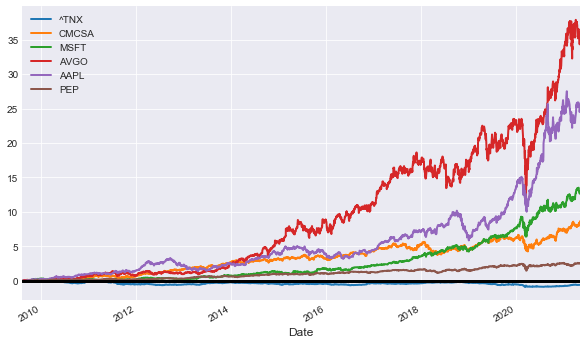

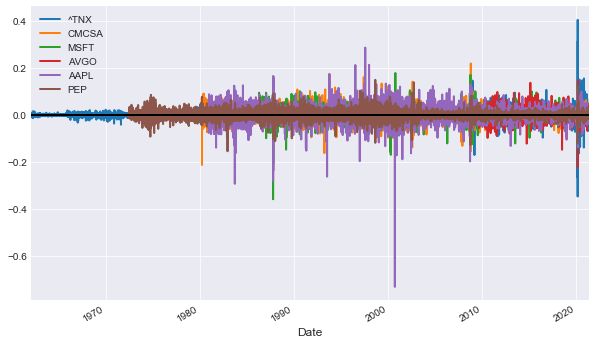

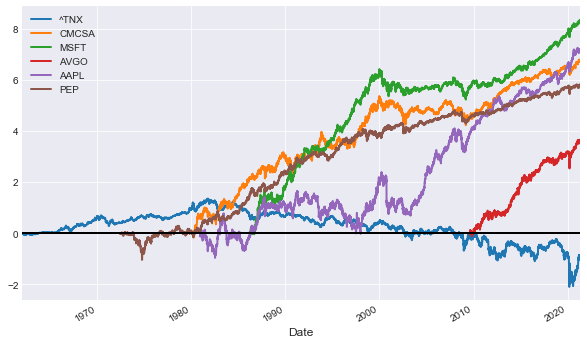

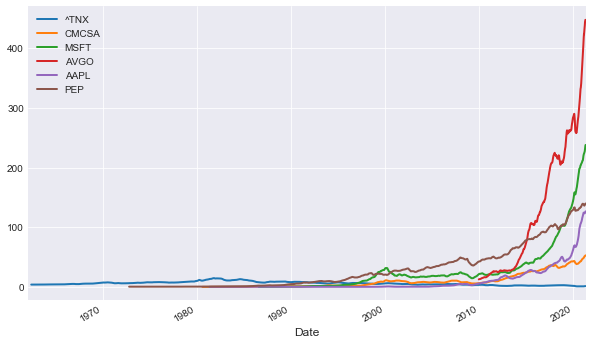

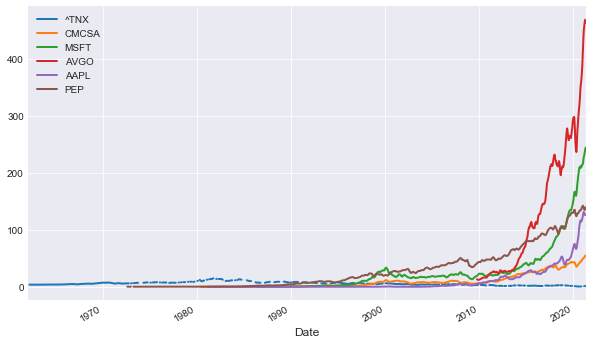

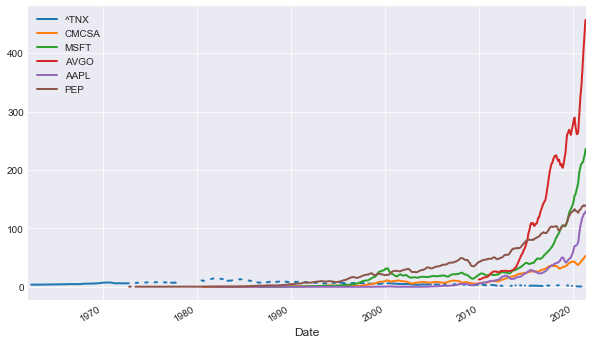

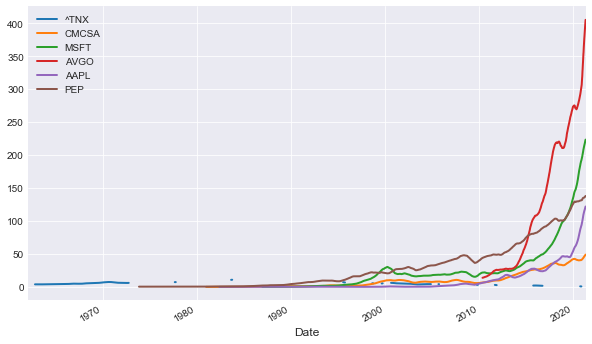

In [65]:
from finquant.moving_average import ema
from finquant.moving_average import sma
graphs ={ }
# plotting cumulative returns (price_{t} - price_{t=0}) / price_{t=0}
plt_cumm_returns, ax = plt.subplots()
ax = pf.comp_cumulative_returns().plot(ax=ax).axhline(y=0, color="black", lw=3)
graphs["Cummulative Returns"] = plt_cumm_returns




# plotting daily log returns
plt_dlog_returns, ax = plt.subplots()
ax= pf.comp_daily_log_returns().plot(ax=ax).axhline(y=0, color="black")

graphs[" Daily Log Returns" ] = plt_dlog_returns

# cumulative log returns
plt_clog_returns, ax = plt.subplots()
ax = pf.comp_daily_log_returns().cumsum().plot(ax=ax).axhline(y=0, color="black")

graphs[" Cumulative Log Returns" ] = plt_clog_returns

# exponential moving average
plt_ema_returns, ax = plt.subplots()

# computing exponential moving average and plotting it
ax= ema(pf.data).plot(ax=ax,grid=True)
#plt.show()
graphs[" Exponential Moving Average" ] = plt_ema_returns


# simple moving average
plt_sma_returns_50, ax = plt.subplots()

# computing simple moving average over a span of 50 (trading) days
# and plotting it
ax = sma(pf.data, span=50).plot(ax=ax,grid=True)

graphs[" Simple Moving Average 50 Days " ] = plt_sma_returns_50

# simple moving average
plt_sma_returns_100, ax = plt.subplots()

# computing simple moving average over a span of 50 (trading) days
# and plotting it
ax = sma(pf.data, span=100).plot(ax=ax,grid=True)
#plt.show()
graphs[" Simple Moving Average 100 Days" ] = plt_sma_returns_100

# simple moving average
plt_sma_returns_200, ax = plt.subplots()

# computing simple moving average over a span of 50 (trading) days
# and plotting it
ax = sma(pf.data, span=200).plot(ax=ax,grid=True)
#plt.show()
graphs[" Simple Moving Average 200 Days" ] = plt_sma_returns_200




BokehModel(combine_events=True, render_bundle={'docs_json': {'7eefe8a8-3734-43f3-ad2c-6dcaf31e0c1e': {'defs': …

Column
    [0] Card(title='Moving Averages f...)
        [0] Matplotlib(Figure)
    [1] Card(title='Moving Averages f...)
        [0] Matplotlib(Figure)
    [2] Card(title='Moving Averages f...)
        [0] Matplotlib(Figure)
    [3] Card(title='Moving Averages f...)
        [0] Matplotlib(Figure)
    [4] Card(title='Moving Averages f...)
        [0] Matplotlib(Figure)
    [5] Card(title='Moving Averages for PEP')
        [0] Matplotlib(Figure)

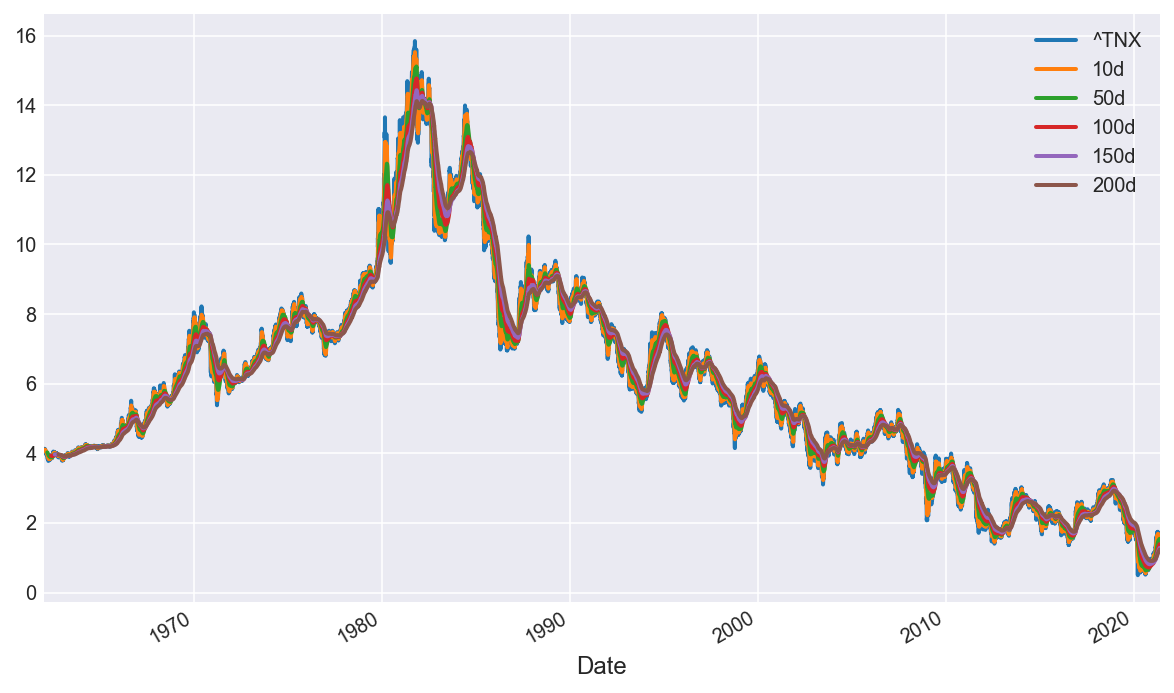

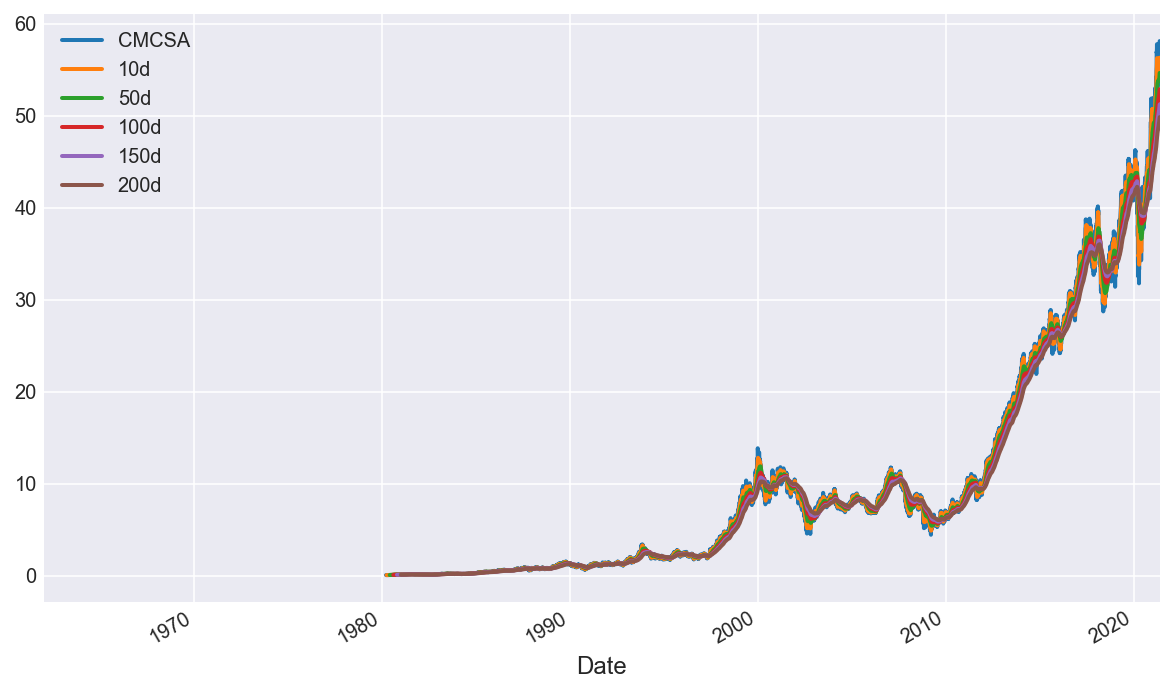

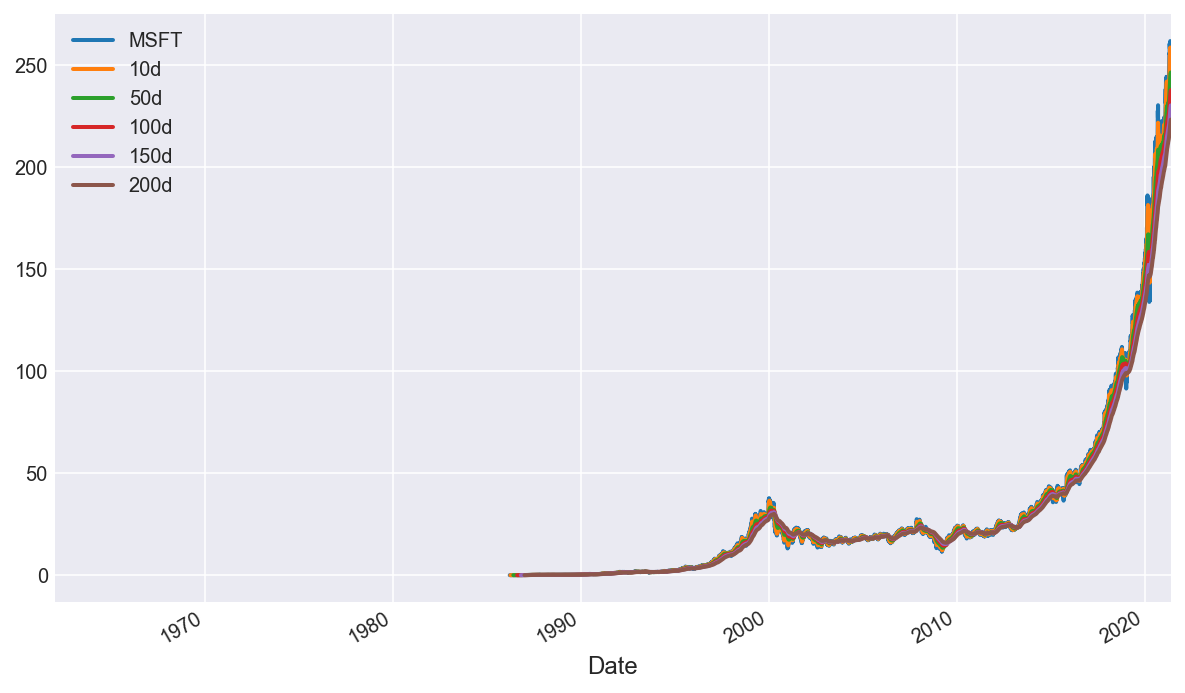

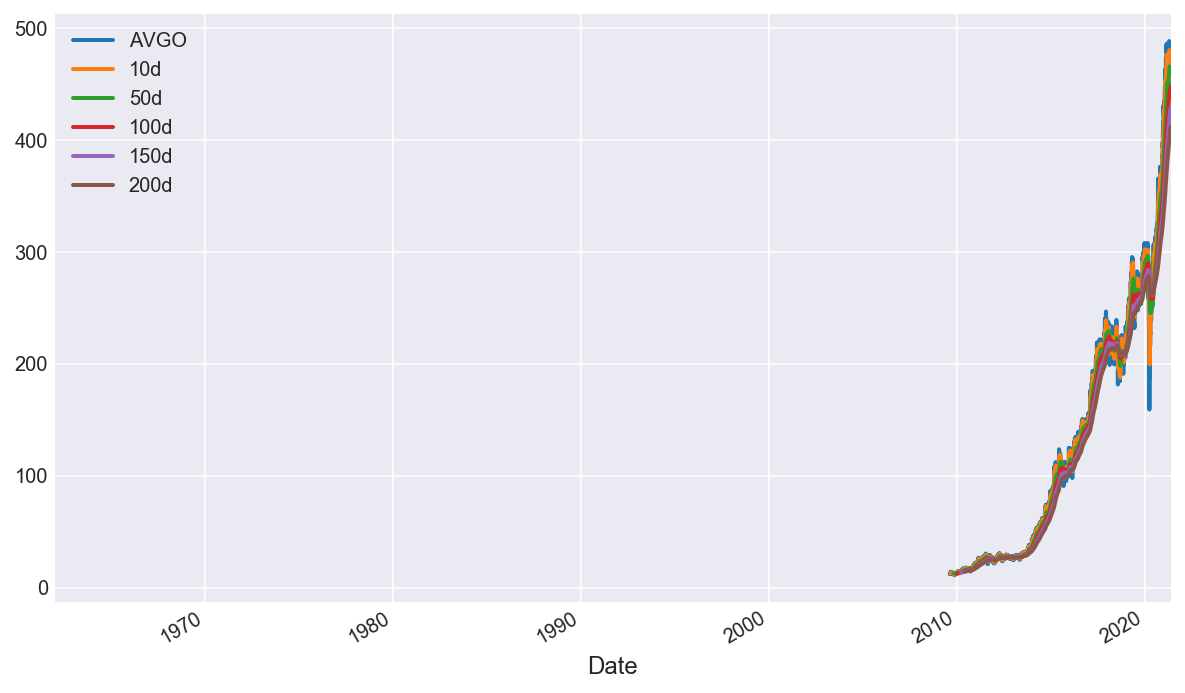

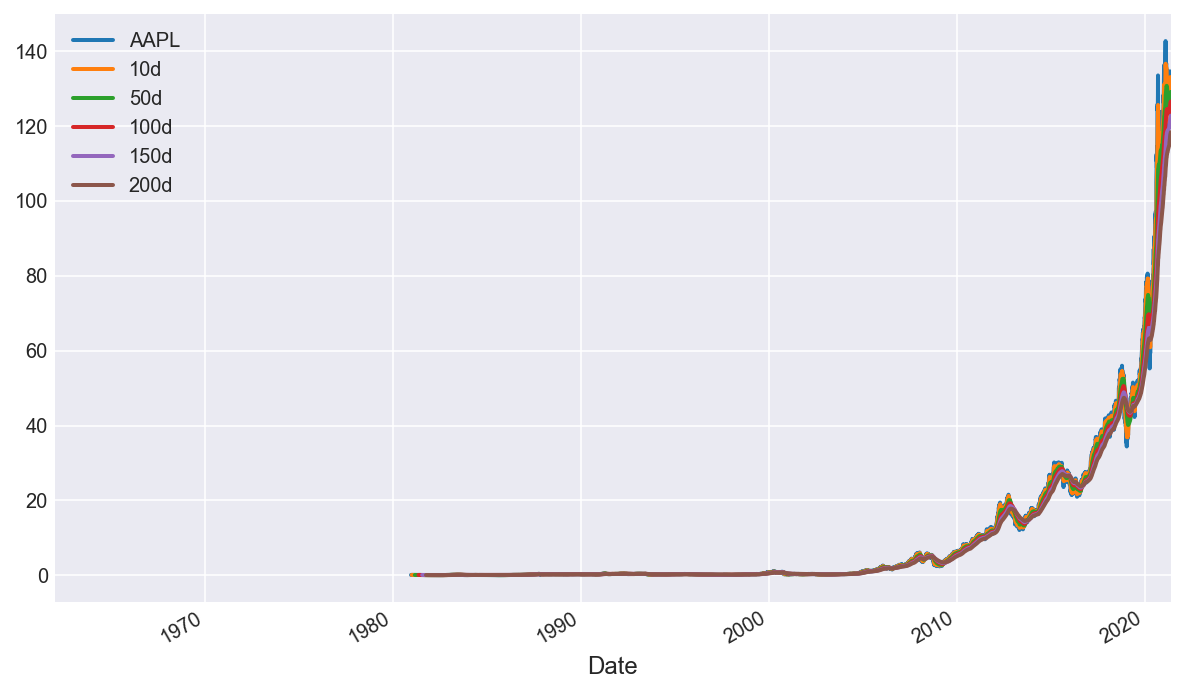

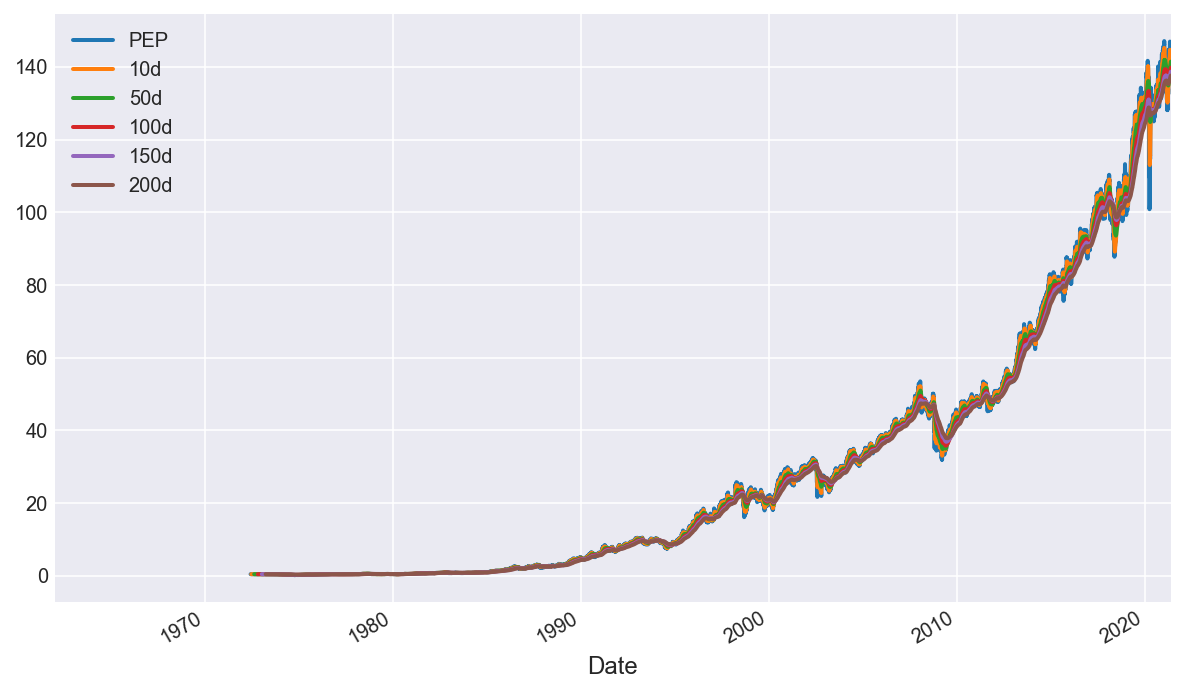

In [67]:
col_indi_ma = pn.Column()

for stock in pf.stocks.keys():
     title = "Moving Averages for "
     st = pf.get_stock(stock).data.copy(deep=True)
     spans = [10, 50, 100, 150, 200]
     st_ma=  compute_ma(st, ema, spans, plot=False)
     plt_st_ma, ax = plt.subplots()
     ax = st_ma.plot(grid=True,ax=ax)
     title = title + stock
     card = pn.Card(plt_st_ma, title=title)
     col_indi_ma.append(card)

col_indi_ma


In [69]:
current=  252
pf.freq = current
pf.risk_free_rate = risk_free_rate

# 2.a compute and get new values based on new freq/risk_free_rate
exret = pf.comp_expected_return(freq=pf.freq)
vol = pf.comp_volatility(freq=pf.freq)
sharpe = pf.comp_sharpe()
print(
    "For {} trading days and a risk free rate of {}:".format(pf.freq, pf.risk_free_rate)
)
print("Expected return: {:0.3f}".format(exret))
print("Volatility: {:0.3f}".format(vol))
print("Sharpe Ratio: {:0.3f}".format(sharpe))
#str_exp_ret=  "Expected return: {:0.3f}".format(exret)
pn_er = pn.indicators.Number(name='Expected return', value=round(exret,2), format='{value}%',
colors=[(33, 'green')])
pn_vol = pn.indicators.Number(name='Volatility', value=round(vol,2), format='{value}',
colors=[(33, 'red')])
pn_sha =pn.indicators.Number(name='Sharpe Ratio', value=round(sharpe,2), format='{value}',
colors=[(33, 'orange')])
row_current = pn.Row(pn_er,pn_vol,pn_sha)

For 252 trading days and a risk free rate of 0.007999999:
Expected return: 0.224
Volatility: 0.210
Sharpe Ratio: 1.027


In [71]:
three_years=  252*3
pf.freq = three_years
pf.risk_free_rate = risk_free_rate

# 2.a compute and get new values based on new freq/risk_free_rate
exret3 = pf.comp_expected_return(freq=pf.freq)
vol3 = pf.comp_volatility(freq=pf.freq)
sharpe3 = pf.comp_sharpe()
print(
    "For {} trading days and a risk free rate of {}:".format(pf.freq, pf.risk_free_rate)
)
print("Expected return: {:0.3f}".format(exret3))
print("Volatility: {:0.3f}".format(vol3))
print("Sharpe Ratio: {:0.3f}".format(sharpe3))
#str_exp_ret=  "Expected return: {:0.3f}".format(exret)
pn_er_three = pn.indicators.Number(name='Expected return', value=round(exret3,2), format='{value}%',
colors=[(33, 'green')])
pn_vol_three = pn.indicators.Number(name='Volatility', value=round(vol3,2), format='{value}',
colors=[(33, 'red')])
pn_sha_three =pn.indicators.Number(name='Sharpe Ratio', value=round(sharpe3,2), format='{value}',
colors=[(33, 'orange')])
row_three_years2= pn.Row(pn_er_three,pn_vol_three,pn_sha_three)

For 756 trading days and a risk free rate of 0.007999999:
Expected return: 0.671
Volatility: 0.364
Sharpe Ratio: 1.823


In [73]:
row_three_years2

BokehModel(combine_events=True, render_bundle={'docs_json': {'65e2a526-f0d2-4660-8e37-ee599bffcd23': {'defs': …

Row
    [0] Number(colors=[(33, 'green')], format='{value}%', name='Expected return', value=0.67)
    [1] Number(colors=[(33, 'red')], name='Volatility', value=0.36)
    [2] Number(colors=[(33, 'orange')], name='Sharpe Ratio', value=1.82)

In [75]:
five_years=  252*5
pf.freq = five_years
pf.risk_free_rate = risk_free_rate

# 2.a compute and get new values based on new freq/risk_free_rate
exret = pf.comp_expected_return(freq=pf.freq)
vol = pf.comp_volatility(freq=pf.freq)
sharpe = pf.comp_sharpe()
print(
    "For {} trading days and a risk free rate of {}:".format(pf.freq, pf.risk_free_rate)
)
print("Expected return: {:0.3f}".format(exret))
print("Volatility: {:0.3f}".format(vol))
print("Sharpe Ratio: {:0.3f}".format(sharpe))
pn_er_five=pn.indicators.Number(name='Expected return', value=round(exret,2), format='{value}%',
colors=[(33, 'green')])
pn_vol_five=pn.indicators.Number(name='Volatility', value=round(vol,2), format='{value}',
colors=[(33, 'red')])
pn_sha_five=pn.indicators.Number(name='Sharpe Ratio', value=round(sharpe,2), format='{value}',
colors=[(33, 'orange')])
row_five_years= pn.Row(pn_er_five,pn_vol_five,pn_sha_five)

For 1260 trading days and a risk free rate of 0.007999999:
Expected return: 1.118
Volatility: 0.469
Sharpe Ratio: 2.365


In [77]:
ten_years_days=  252*10
pf.freq = ten_years_days
pf.risk_free_rate = risk_free_rate

# 2.a compute and get new values based on new freq/risk_free_rate
exret = pf.comp_expected_return(freq=pf.freq)
vol = pf.comp_volatility(freq=pf.freq)
sharpe = pf.comp_sharpe()
print(
    "For {} trading days and a risk free rate of {}:".format(pf.freq, pf.risk_free_rate)
)
print("Expected return: {:0.3f}".format(exret))
print("Volatility: {:0.3f}".format(vol))
print("Sharpe Ratio: {:0.3f}".format(sharpe))
pn_er_ten= pn.indicators.Number(name='Expected return', value=round(exret,2), format='{value}%',
colors=[(33, 'green')])
pn_vol_ten=pn.indicators.Number(name='Volatility', value=round(vol,2), format='{value}',
colors=[(33, 'red')])
pn_sha_ten=pn.indicators.Number(name='Sharpe Ratio', value=round(sharpe,2), format='{value}',
colors=[(33, 'orange')])
row_ten_years= pn.Row(pn_er_ten,pn_vol_ten,pn_sha_ten)

For 2520 trading days and a risk free rate of 0.007999999:
Expected return: 2.236
Volatility: 0.664
Sharpe Ratio: 3.356


In [79]:
card_ret_current= pn.Card(row_curr, title="Current Year")
card_ret_three= pn.Card(row_three_years2, title="Three Years")
card_ret_five= pn.Card(row_five_years, title="Five Years")
card_ret_ten= pn.Card(row_five_years, title="Ten Years")

NameError: name 'row_curr' is not defined

In [81]:
row1= pn.Row()
row2= pn.Row()
column= pn.Column()
col = 0
for graph in graphs.keys():
    #mpl_pane = pn.pane(graphs[graph], dpi=144)
    card = pn.Card(graphs[graph], title=graph)
    if col < 3:
        row1.append(card)
        col += 1
    else:
        row2.append(card)
        col += 1

column.append(row1)
column.append(row2)



In [512]:
import panel as pn
import numpy as np
import holoviews as hv
pn.extension(comms="vscode")
pn.config.sizing_mode = 'stretch_width'

In [517]:
   row_returns = pn.Column(
        pn.Card(row_current, title="Current Year"),
        pn.Card(row_three_years2, title="Three Years"),
        pn.Card(row_five_years, title="Five Years"),
        pn.Card(row_ten_years, title="Ten Years")
    )

In [518]:
tabs = pn.Tabs(
('Returns Information', row_returns),    
('Portfolio Anlaysis', column),
("Individual Stock Analysis",col_indi_ma),
)
tabs

BokehModel(combine_events=True, render_bundle={'docs_json': {'515d2627-3dfb-4611-a311-c1787bfd4702': {'defs': …

Tabs(sizing_mode='stretch_width')
    [0] Column(sizing_mode='stretch_width')
        [0] Card(sizing_mode='stretch_width', title='Current Year')
            [0] Row(sizing_mode='stretch_width')
                [0] Number(colors=[(33, 'green')], format='{value}%', name='Expected return', value=0.22)
                [1] Number(colors=[(33, 'red')], name='Volatility', value=0.21)
                [2] Number(colors=[(33, 'orange')], name='Sharpe Ratio', value=1.02)
        [1] Card(sizing_mode='stretch_width', title='Three Years')
            [0] Row(sizing_mode='stretch_width')
                [0] Number(colors=[(33, 'green')], format='{value}%', name='Expected return', value=0.67)
                [1] Number(colors=[(33, 'red')], name='Volatility', value=0.36)
                [2] Number(colors=[(33, 'orange')], name='Sharpe Ratio', value=1.82)
        [2] Card(sizing_mode='stretch_width', title='Five Years')
            [0] Row(sizing_mode='stretch_width')
                [0] Number(colors=[(33, 'green')], format='{value}%', name='Expected return', value=1.12)
                [1] Number(colors=[(33, 'red')], name='Volatility', value=0.47)
                [2] Number(colors=[(33, 'orange')], name='Sharpe Ratio', value=2.37)
        [3] Card(sizing_mode='stretch_width', title='Ten Years')
            [0] Row(sizing_mode='stretch_width')
                [0] Number(colors=[(33, 'green')], format='{value}%', name='Expected return', value=2.25)
                [1] Number(colors=[(33, 'red')], name='Volatility', value=0.66)
                [2] Number(colors=[(33, 'orange')], name='Sharpe Ratio', value=3.36)
    [1] Column(sizing_mode='stretch_width')
        [0] Row(sizing_mode='stretch_width')
            [0] Card(sizing_mode='stretch_width', title='Cummulative Returns')
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
            [1] Card(sizing_mode='stretch_width', title=' Daily Log Returns')
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
            [2] Card(sizing_mode='stretch_width', title=' Cumulative Log Returns')
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [1] Row(sizing_mode='stretch_width')
            [0] Card(sizing_mode='stretch_width', title=' Exponential M...)
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
            [1] Card(sizing_mode='stretch_width', title=' Simple Moving A...)
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
            [2] Card(sizing_mode='stretch_width', title=' Simple Moving A...)
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
            [3] Card(sizing_mode='stretch_width', title=' Simple Moving A...)
                [0] Matplotlib(Figure, sizing_mode='stretch_width')
    [2] Column(sizing_mode='stretch_width')
        [0] Card(sizing_mode='stretch_width', title='Moving Averages f...)
            [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [1] Card(sizing_mode='stretch_width', title='Moving Averages f...)
            [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [2] Card(sizing_mode='stretch_width', title='Moving Averages f...)
            [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [3] Card(sizing_mode='stretch_width', title='Moving Averages f...)
            [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [4] Card(sizing_mode='stretch_width', title='Moving Averages f...)
            [0] Matplotlib(Figure, sizing_mode='stretch_width')
        [5] Card(sizing_mode='stretch_width', title='Moving Averages for PEP')
            [0] Matplotlib(Figure, sizing_mode='stretch_width')

In [478]:
from bokeh.resources import INLINE
tabs.save('port_report.html', resources=INLINE)

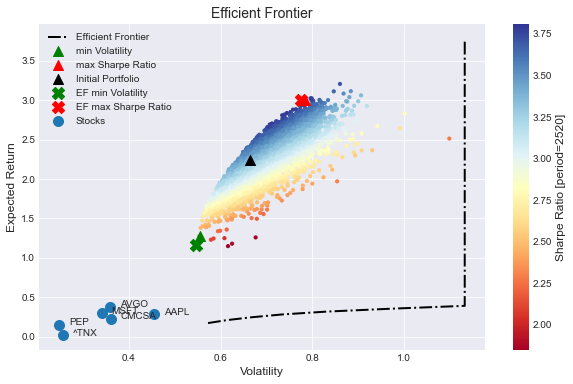

In [452]:
from finquant.efficient_frontier import EfficientFrontier
opt_w, opt_res = pf.mc_optimisation(num_trials=5000)
pf.mc_plot_results()
pf.ef_plot_efrontier()
pf.ef.plot_optimal_portfolios()
pf.plot_stocks()
plt.show()

In [453]:
print(opt_w)

                      ^TNX     CMCSA      MSFT      AVGO      AAPL       PEP
Min Volatility    0.390237  0.113398  0.017405  0.076015  0.011038  0.391907
Max Sharpe Ratio  0.001841  0.022118  0.322730  0.440010  0.011882  0.201420


In [454]:
print(opt_res)

                  Expected Return  Volatility  Sharpe Ratio
Min Volatility           1.276911    0.554172      2.286132
Max Sharpe Ratio         2.999286    0.784885      3.808565
